## Understand The Problem Statement & Business Case

- Artificial Intelligence and Machine Learning are transforming the manufacturing industry. According to the report released by World Economic Forum, these technologies will play significant roles in the fourth industrial revolution. Major areas which can be benefited from this are:
    - Maintenance Department
    - Production Department
    - Supply Chain Department

- Deep learning has been proven to be superior in detecting and localizing defects using imagery data which could significantly improve the production efficiency in the manufacturing industry.
- Great Example from LandingAI: https://landing.ai/defect-detection/

- In this case study, we will assume that you work as an AI/ML consultant. 
- You have been hired by a steel manufacturing company in San Diego and you have been tasked to automate the process of detecting and localizing defects found in Steel manufacturing.
- Detecting defects would help in improving the quality of manufacturing as well as in reducing the waste due to production defects.
- The team has collected images of steel surfaces and have approached you to develop a model that could detect and localize defects in real-time. 
- You have been provided with 12600 images that contain 4 types of defects, along with their location in the steel surface.

### What is Image Segmentation:

- The goal of image segmentation is to understand and extract information from images at the pixel-level. 
- Image Segmentation can be used for object recognition and localization which offers tremendous value in many applications such as medical imaging and self-driving cars etc.
- The goal of image segmentation is to train a neural network to produce pixel-wise mask of the image.
- Modern image segmentation techniques are based on deep learning approach which makes use of common architectures such as CNN, FCNs (Fully Convolution Networks) and Deep Encoders-Decoders.
- We will be using ResUNet architecture to solve the current task. 

- In case of Unet, we convert (encode) the image into a vector followed by up sampling (decode) it back again into an image. 
- In using Unet, the input and output have the same size so the size of the image is preserved. 
- For classical CNNs: they are generally used when the entire image is needed to be classified as a class label. 
- For Unet: pixel level classification is performed.
- U-net formulates a loss function for every pixel in the input image.
- Softmax function is applied to every pixel which makes the segmentation problem works as a classification problem where classification is performed on every pixel of the image. 


## Import Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')


### Mask:

- The goal of image segmentation is to understand the image at the pixel level. It associates each pixel with a certain class. The output produce by image segmentation model is called a “mask” of the image.
- Masks can be represented by associating pixel values with their coordinates. For example if we have a black image of shape (2,2), this can be represented as: 
                         [[ 0, 0],
                      [0, 0]]
- If our output mask is as follows:
                                [[255, 0],
            [0,255]]
- To represent this mask we have to first flatten the image into a 1-D array. This would result in something like [255,0,0,255] for mask. Then, we can use the index to create the mask. Finally we would have something like [1,0,0,1] as our mask.

### Run Length Encoding (RLE):

- Sometimes it is hard to represent mask using index as it would make the length of mask equal to product of height and width of the image
- To overcome this we use lossless data compression technique called Run-length encoding (RLE), which stores sequences that  contain many consecutive data elements as a single data value followed by the count.
- For example, assume we have an image (single row) containing plain black text on a solid white background. B represents black pixel and W represents white:
        WWWWWWWWWWWWBWWWWWWWWWWWWBBBWWWWWWWWWWWWWWWWWWWWWWWWBWWWWWWWWWWWWWW
- Run Length Encoding (RLE):
        12W1B12W3B24W1B14W
- This can be interpreted as a sequence of twelve Ws, one B, twelve Ws, three Bs, etc.,

In [ ]:
# Data containing defect images with segmentation mask
defect_class_mask_df = pd.read_csv('Defect Detection Model/train.csv')


In [ ]:
# Data containing defective and non defective images
all_images_df = pd.read_csv('Defect Detection Model/defect_and_no_defect.csv')


In [4]:
defect_class_mask_df

ImageId  ClassId  \
0     d2291de5c.jpg        1   
1     78416c3d0.jpg        3   
2     2283f2183.jpg        3   
3     f0dc068a8.jpg        3   
4     00d639396.jpg        3   
...             ...      ...   
5743  c12842f5e.jpg        3   
5744  2222a03b3.jpg        3   
5745  b43ea2c01.jpg        1   
5746  1bc37a6f4.jpg        3   
5747  f4413e172.jpg        3   

                                          EncodedPixels  
0     147963 3 148213 9 148461 18 148711 24 148965 2...  
1     54365 3 54621 7 54877 10 55133 12 55388 14 556...  
2     201217 43 201473 128 201729 213 201985 5086 20...  
3     159207 26 159412 77 159617 128 159822 179 1600...  
4     229356 17 229595 34 229850 36 230105 37 230360...  
...                                                 ...  
5743  88 23 342 29 596 34 850 39 1105 44 1361 46 161...  
5744  63332 4 63587 11 63841 20 64096 27 64351 35 64...  
5745  185024 7 185279 11 185535 12 185790 13 186045 ...  
5746  303867 1 304122 3 304376 6 304613 3 304630 9 3...  
5747  254911 3 255165 8 255419 12 255672 18 255926 2...  

[5748 rows x 3 columns]

In [5]:
all_images_df

ImageID  label
0      0002cc93b.jpg      1
1      0007a71bf.jpg      1
2      000a4bcdd.jpg      1
3      000f6bf48.jpg      1
4      0014fce06.jpg      1
...              ...    ...
12992  0482ee1d6.jpg      0
12993  04802a6c2.jpg      0
12994  03ae2bc91.jpg      0
12995  04238d7e3.jpg      0
12996  023353d24.jpg      0

[12997 rows x 2 columns]

## Visualize & Explore Dataset

In [6]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [7]:
defect_class_mask_df.head(50)

ImageId  ClassId                                      EncodedPixels  \
0   d2291de5c.jpg        1  147963 3 148213 9 148461 18 148711 24 148965 2...   
1   78416c3d0.jpg        3  54365 3 54621 7 54877 10 55133 12 55388 14 556...   
2   2283f2183.jpg        3  201217 43 201473 128 201729 213 201985 5086 20...   
3   f0dc068a8.jpg        3  159207 26 159412 77 159617 128 159822 179 1600...   
4   00d639396.jpg        3  229356 17 229595 34 229850 36 230105 37 230360...   
5   17d02873a.jpg        3  254980 43 255236 127 255492 211 255748 253 256...   
6   47b5ab1bd.jpg        3  128976 8 129230 12 129484 16 129739 23 129995 ...   
7   a6ecee828.jpg        3  179011 27 179126 73 179259 39 179375 80 179497...   
8   11aaf18e2.jpg        3  303235 2 303489 7 303743 9 303997 11 304181 2 ...   
9   cdf669a1f.jpg        4  310246 11 310499 25 310753 28 311007 31 311262...   
10  fb9558035.jpg        4  159233 1 159489 2 159745 4 160001 5 160257 6 1...   
11  9fac588ab.jpg        3  68321 32 68513 96 68706 159 68930 191 69186 19...   
12  83d9b39c8.jpg        3  175089 15 175313 47 175538 78 175762 110 17598...   
13  749407e33.jpg        3  15704 3 15960 8 16216 13 16471 19 16727 23 169...   
14  e2bdd4236.jpg        3  17490 175 17746 175 18002 175 18258 175 18514 ...   
15  8bab4626b.jpg        3  37390 2 37644 5 37898 7 38151 11 38405 13 3865...   
16  3bde297da.jpg        3  154381 5 154635 17 154889 27 155143 36 155397 ...   
17  ff5483763.jpg        3  168785 7 169034 20 169284 33 169533 46 169779 ...   
18  a369c5c1f.jpg        3  18358 11 18606 32 18854 53 19102 73 19225 6 19...   
19  d62e553a8.jpg        3  11453 1 11709 2 11964 4 12220 5 12475 7 12731 ...   
20  ceccb1eef.jpg        1  361364 18 361613 42 361862 55 362112 67 362337...   
21  eda5114ee.jpg        3  38877 2 39129 6 39381 10 39633 14 39885 18 401...   
22  23c450c03.jpg        1  9251 24 9505 29 9759 32 10013 36 10267 39 1032...   
23  ab6afa374.jpg        3  65986 39 66165 116 66344 193 66561 232 66817 2...   
24  a0906d0b3.jpg        4  213842 5 214096 9 214351 11 214605 15 214860 1...   
25  5562229c3.jpg        3  22966 17 23189 49 23412 82 23636 113 23859 145...   
26  2365be47a.jpg        3  31096 3 31352 7 31608 12 31863 17 32119 21 323...   
27  737ae5c95.jpg        4  50890 4 51146 6 51401 8 51657 9 51912 11 52048...   
28  f89ce1e24.jpg        3  325112 9 325352 25 325592 41 325832 57 326071 ...   
29  a239718e1.jpg        3  322214 4 322470 12 322726 20 322982 28 323238 ...   
30  2694c98fb.jpg        3  212692 11 212928 31 213164 51 213400 71 213636...   
31  a9108753d.jpg        3  3244 4 3494 10 3743 18 3993 24 4245 28 4501 29...   
32  c4f5ebbb2.jpg        4  229758 5 230006 13 230254 21 230502 29 230750 ...   
33  75361926d.jpg        4  144404 7 144652 17 144906 20 145160 24 145414 ...   
34  fc8cb11db.jpg        1  271869 4 272115 14 272358 27 272601 40 272845 ...   
35  9f054c54f.jpg        1  191060 15 191309 24 191563 29 191818 32 191889...   
36  faea44200.jpg        3  308123 102 308379 102 308635 102 308891 102 30...   
37  9b72243dc.jpg        3  207915 9 208167 28 208385 2 208420 44 208641 6...   
38  10bbf7cb3.jpg        3  324770 1 325024 5 325278 8 325533 11 325787 14...   
39  d1cd969d5.jpg        3  307684 6 307916 7 307937 11 308167 13 308191 1...   
40  1082cfe08.jpg        4  240140 9 240395 27 240650 46 240905 64 241160 ...   
41  927be944d.jpg        1  26369 15 26625 30 26881 30 27137 30 27393 31 2...   
42  0518e79e9.jpg        3  154369 38 154625 42 154881 46 155137 50 155393...   
43  64934ac51.jpg        3  357377 28 357633 83 357889 130 358145 169 3584...   
44  26b0e74fe.jpg        3  156299 6 156545 16 156791 25 157037 35 157283 ...   
45  7b2257638.jpg        3  77828 64 78084 190 78340 253 78596 253 78852 2...   
46  975f12b62.jpg        3  185857 11 186113 31 186369 51 186625 72 186881...   
47  92932546c.jpg        3  53236 13 53468 37 53700 61 53931 86 54163 110 ...   
48  464a009f9.jpg        3  81550 10 8179

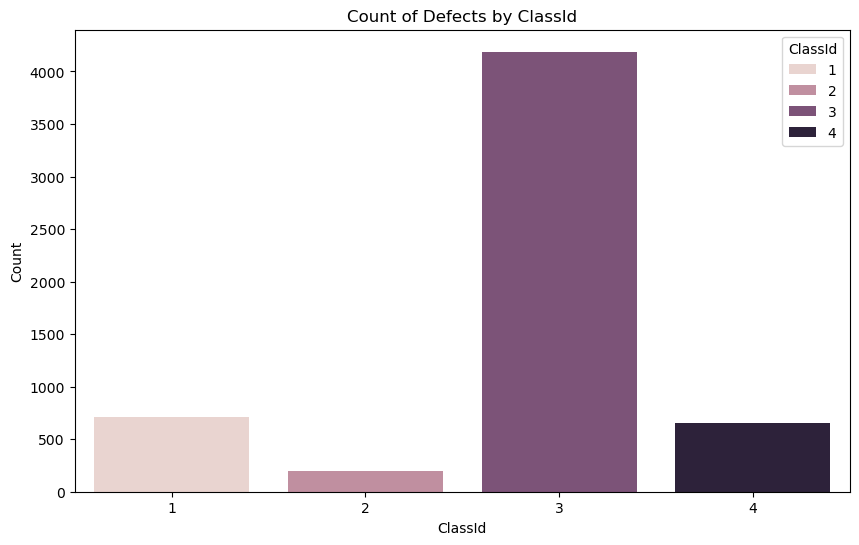

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x = 'ClassId', data = defect_class_mask_df, hue ='ClassId')
plt.title('Count of Defects by ClassId')
plt.xlabel('ClassId')
plt.ylabel('Count')
plt.show()

Some images are classified with more than one defect, let's explore this further

In [9]:
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [10]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [11]:
defect_type.value_counts()

mask
1    5201
2     272
3       1
Name: count, dtype: int64

- We have one image with 3 types of defects
- We have 272 images with 2 types of defects
- We have 5201 images with 1 type of defect

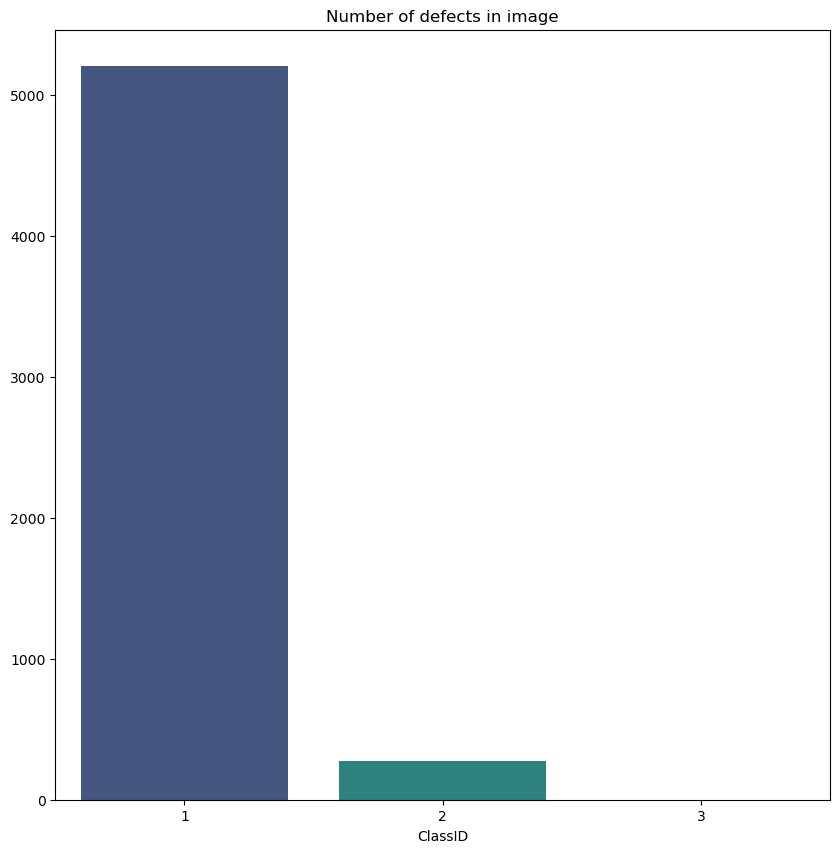

In [12]:
plt.figure(figsize=(10,10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts().values, palette = 'viridis')
plt.xlabel('ClassID')
plt.title('Number of defects in image')
plt.show();

In [13]:
defect_class_mask_df.shape

(5748, 4)

In [14]:
all_images_df.shape

(12997, 2)

In [15]:
# Count defective and non defective images
all_images_df.label.value_counts()

label
1    7095
0    5902
Name: count, dtype: int64

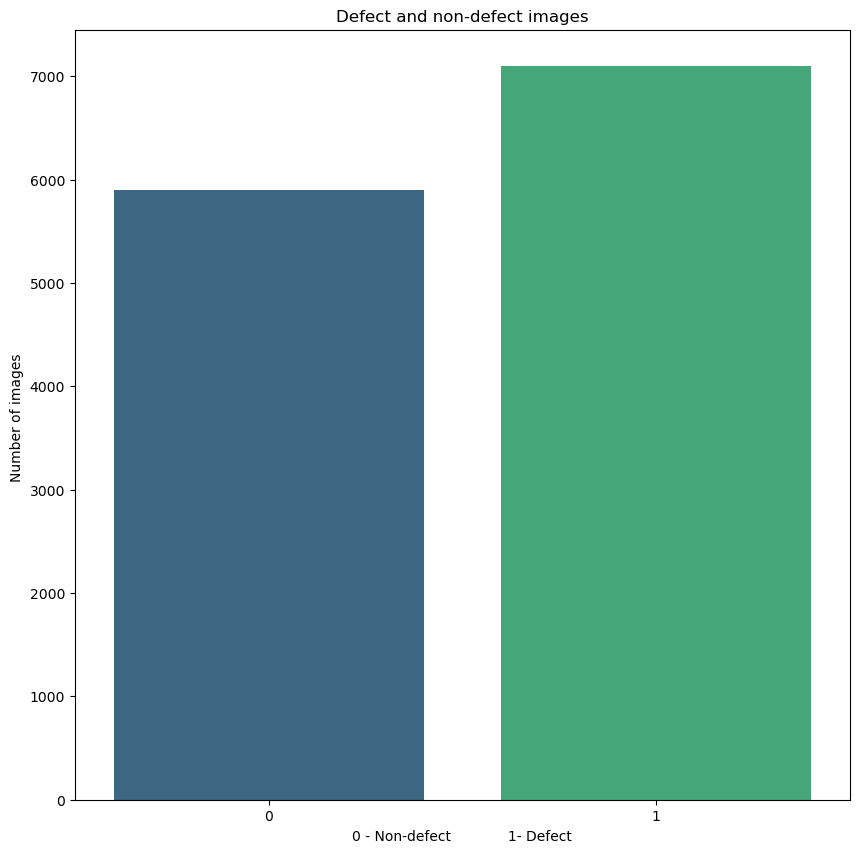

In [16]:
plt.figure(figsize=(10,10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts(), palette = 'viridis')
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')
plt.show();

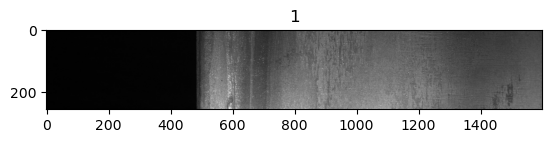

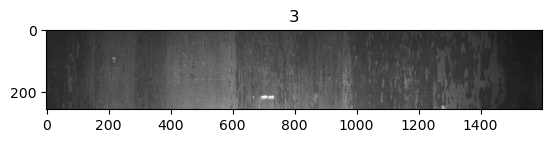

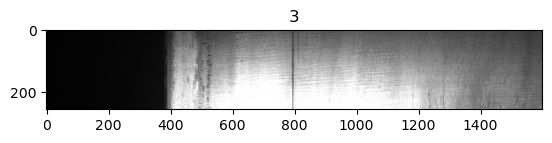

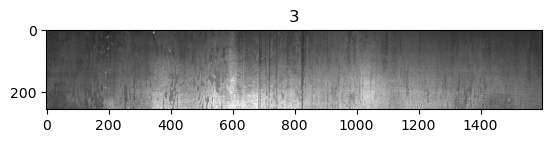

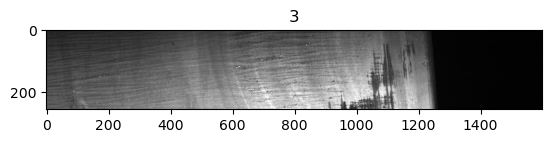

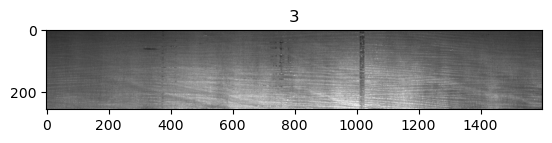

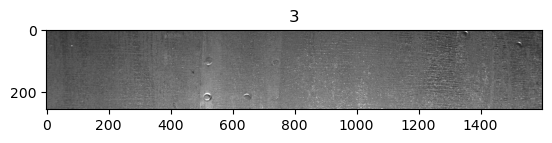

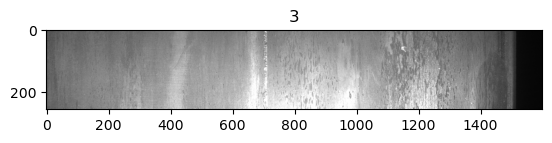

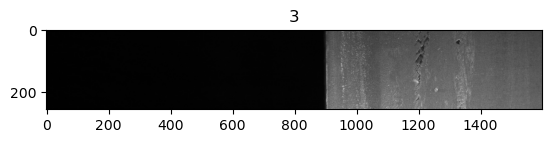

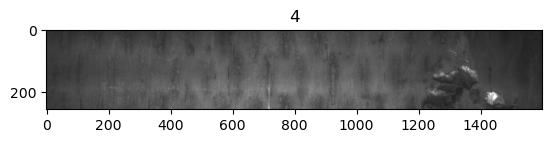

In [ ]:
# Visualize images with defects along with their corresponding labels
# Images are 256 x 1600 pixels
train_dir = 'Defect Detection Model/train_images'

for i in range(10):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)
  plt.show();


In [ ]:
# Utilities file contains the code for rle2mask, mask2rle, custom loss function and custom data generator
# Since the data provided for segmentation is in RLE format (run length encoded), we will be using the following function to convert the RLE to mask.
# We can convert the mask back again to RLE to assess model performance (accuracy).
# Code source for these function came from: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

from utilities import rle2mask , mask2rle

train_dir = 'Defect Detection Model/train_images'



In [19]:
defect_class_mask_df

ImageId  ClassId  \
0     d2291de5c.jpg        1   
1     78416c3d0.jpg        3   
2     2283f2183.jpg        3   
3     f0dc068a8.jpg        3   
4     00d639396.jpg        3   
...             ...      ...   
5743  c12842f5e.jpg        3   
5744  2222a03b3.jpg        3   
5745  b43ea2c01.jpg        1   
5746  1bc37a6f4.jpg        3   
5747  f4413e172.jpg        3   

                                          EncodedPixels  mask  
0     147963 3 148213 9 148461 18 148711 24 148965 2...     1  
1     54365 3 54621 7 54877 10 55133 12 55388 14 556...     1  
2     201217 43 201473 128 201729 213 201985 5086 20...     1  
3     159207 26 159412 77 159617 128 159822 179 1600...     1  
4     229356 17 229595 34 229850 36 230105 37 230360...     1  
...                                                 ...   ...  
5743  88 23 342 29 596 34 850 39 1105 44 1361 46 161...     1  
5744  63332 4 63587 11 63841 20 64096 27 64351 35 64...     1  
5745  185024 7 185279 11 185535 12 185790 13 186045 ...     1  
5746  303867 1 304122 3 304376 6 304613 3 304630 9 3...     1  
5747  254911 3 255165 8 255419 12 255672 18 255926 2...     1  

[5748 rows x 4 columns]

In [20]:
# Use the rle2mask on a sample image
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

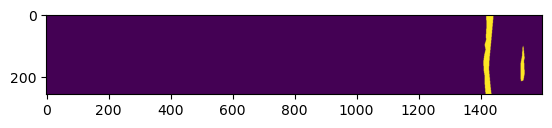

In [21]:
# Show the mask
plt.imshow(mask)
plt.show();

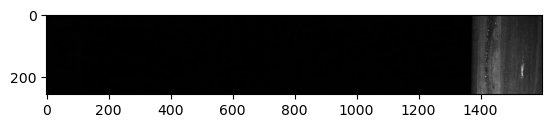

(256, 1600, 3)

In [22]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
plt.show();
img.shape

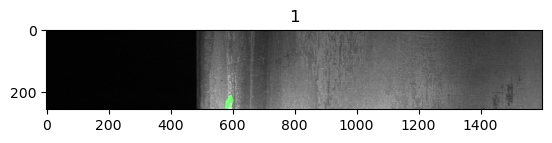

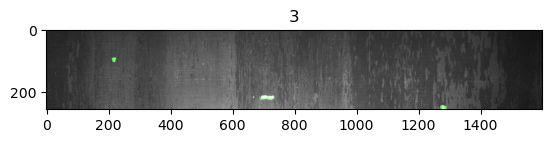

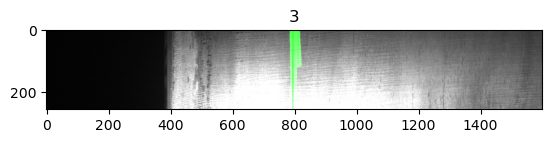

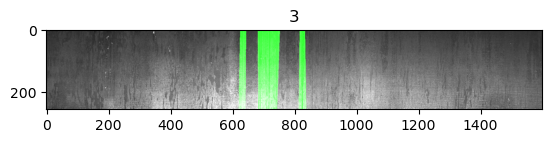

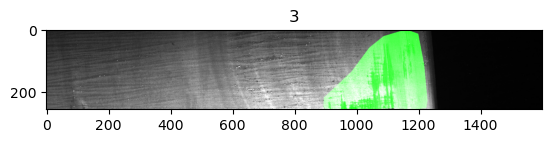

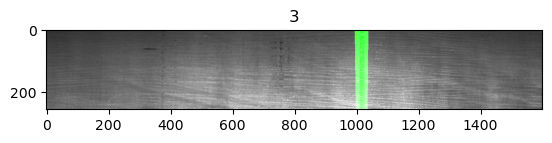

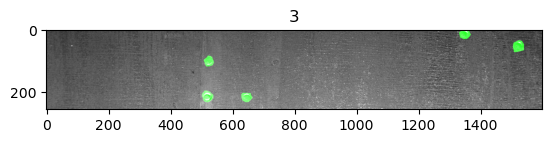

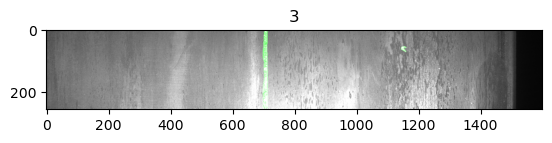

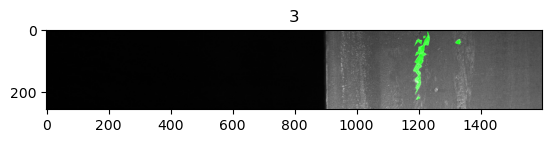

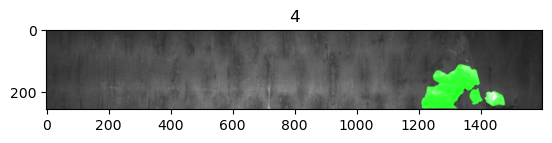

In [23]:
for i in range(10):

  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])

  # Let's color the pixels with values = 1
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])
  plt.show();


## Understand the Theory & Intuition Behind Convolutional Neural Networks, Resnets, & Transfer Learning

### Convolutional Neural Networks

- The first CNN layers are used to extract high level general features. 
- The last couple of layers are used to perform classification (on a specific task).
- Local respective fields scan the image first searching for simple shapes such as edges/lines 
- These edges are then picked up by the subsequent layer to form more complex features.

### Resnet (Residual Network)

- As CNNs grow deeper, vanishing gradient tend to occur which negatively impact network performance.
- Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers which results in a very small gradient. 
- Residual Neural Network includes “skip connection” feature which enables training of 152 layers without vanishing gradient issues. 
- Resnet works by adding “identity mappings” on top of the CNN. 
- ImageNet contains 11 million images and 11,000 categories. 
- ImageNet is used to train ResNet deep network.

### Transfer Learning

- Transfer learning is a machine learning technique in which a network that has been trained to perform a specific task is being reused (repurposed) as a starting point for another similar task.
- Transfer learning is widely used since starting from a pre-trained models can dramatically reduce the computational time required if training is performed from scratch. 

### Transfer Learning Strategies

- Strategy #1 Steps: 
    - Freeze the trained CNN network weights from the first layers. 
    - Only train the newly added dense layers (with randomly initialized weights).
- Strategy #2 Steps: 
    - Initialize the CNN network with the pre-trained weights 
    - Retrain the entire CNN network while setting the learning rate to be very small, this is critical to ensure that you do not aggressively change the trained weights.
- Transfer learning advantages are:
    - Provides fast training progress, you don’t have to start from scratch using randomly initialized weights
    - You can use small training dataset to achieve incredible results


## Build & Train a Deep Learning Model to Detect a Defect in an Image

In [24]:
all_images_df

ImageID  label
0      0002cc93b.jpg      1
1      0007a71bf.jpg      1
2      000a4bcdd.jpg      1
3      000f6bf48.jpg      1
4      0014fce06.jpg      1
...              ...    ...
12992  0482ee1d6.jpg      0
12993  04802a6c2.jpg      0
12994  03ae2bc91.jpg      0
12995  04238d7e3.jpg      0
12996  023353d24.jpg      0

[12997 rows x 2 columns]

In [25]:
# Split the data (defective and non defective) into training and testing
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)

In [26]:
train.shape

(11047, 2)

In [27]:
test.shape

(1950, 2)

In [ ]:
train_dir = 'Defect Detection Model/train_images'

In [29]:
# Image generator for the training and validation dataset
# Divides the data to training, validation and testing
# Training = 9390
# Validation = 1657
# Testing = 1950

from keras_preprocessing.image import ImageDataGenerator

# Data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [30]:
# Data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))



Found 1950 validated image filenames.


In [31]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

In [32]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [33]:
# Freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [34]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [35]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ["accuracy"])

In [36]:
# Used early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "resnet-weights.keras", verbose = 1, save_best_only = True)

In [37]:
# ~ 90 minutes to train
# history = model.fit(train_generator, steps_per_epoch = train_generator.n // 16, epochs = 40, validation_data = valid_generator, validation_steps = valid_generator.n // 16, callbacks = [checkpointer, earlystopping])

In [38]:
# Save the trained model architecture for future use

model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

## Assess Trained Model Performance

In [ ]:
with open('Defect Detection Model/resnet-classifier-model.json', 'r') as json_file:
    json_savedModel = json_file.read()
# Load the model
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('Defect Detection Model/weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ["accuracy"])

In [40]:
# Make prediction (~10 mins)

from keras_preprocessing.image import ImageDataGenerator
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose = 1)

121/121 ━━━━━━━━━━━━━━━━━━━━ 73s 599ms/step


In [41]:
test_predict

array([[9.9936545e-01],
       [9.9999917e-01],
       [6.3826516e-03],
       ...,
       [1.0096346e-02],
       [9.9979973e-01],
       [1.1249411e-08]], dtype=float32)

- Since we have used sigmoid activation at the end, our result would contain continuous values from 0 to 1.
- The network is initially used to classify whether the image has defect or not.
- Then these images (defective) is passed through the segmentation network to get the localization and type of defect.

In [42]:
# Choosing 0.01, to make sure, that we omit images from passing through the segmentation network only we are highly certain that it has no defect and if we are not confident, we can pass this image through the segmentation network.
predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [43]:
len(predict)

1936

In [44]:
# Because test generator was used, it limited the images to 1936, due to batch size. We need to get the original labels for the test images.

original = np.asarray(test.label)[:1936]
len(original)

1936

In [45]:
# Accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
print(f"Accuracy of the model is: {accuracy}")

Accuracy of the model is: 0.8703512396694215


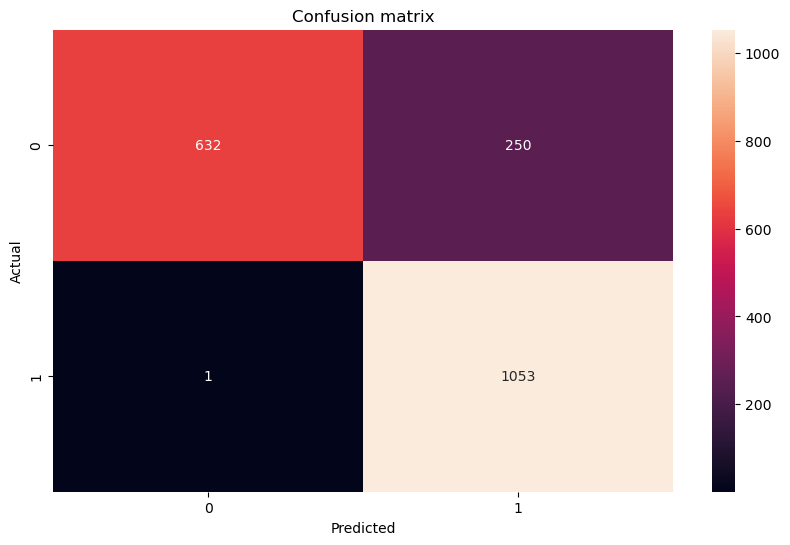

In [46]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show();

In [47]:
# Classification report

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.72      0.83       882
           1       0.81      1.00      0.89      1054

    accuracy                           0.87      1936
   macro avg       0.90      0.86      0.86      1936
weighted avg       0.89      0.87      0.87      1936



## Understand the Theory & Intuition Behind Resunet (Segmentation)

### Resunet

- ResUNet architecture combines UNet backbone architecture with residual blocks to overcome the vanishing gradients problems present in deep architectures.
- Unet architecture is based on Fully Convolutional Networks and modified in a way that it performs well on segmentation tasks.
- Resunet consists of three parts:
    - (1) Encoder or contracting path
    - (2) Bottleneck 
    - (3) Decoder or expansive path 

### Resunet Architecture:

Contraction Path (Encoders):
- The contraction path consist of several contraction blocks, each block takes an input that passes through res-blocks followed by 2x2 max pooling. Feature maps after each block doubles, which helps the model learn complex features effectively.

Bottleneck:
- The bottleneck block, serves as a connection between contraction path and expansion path. 
- The block takes the input and then passes through a res-block followed by 2x2 up-sampling convolution layers.

Expansion Path (Decoder):
- Significant advantage of this architecture lies in expansion or decoder section. Each block takes in the up-sampled input from the previous layer and concatenates with the corresponding output features from the res-blocks in the contraction path. This is then again passed through the res-block followed by 2x2 up-sampling convolution layers.
- This helps to ensure that features learned while contracting are used while reconstructing the image.
- Finally in the last layer of expansion path, the output from the res-block is passed through 1x1 convolution layer to produce the desired output with the same size as the input.


1. Encoder or contracting path consist of 4 blocks: 
    - First block consists of 3x3 convolution layer +  Relu + Batch-Normalization
    - Remaining three blocks consist of  Res-blocks followed by Max-pooling 2x2.

2. Bottleneck:
    - It is in-between the contracting and expanding path. 
    - It consist of Res-block followed by up sampling conv layer 2x2.

3. Expanding or Decoder path consist of 4 blocks:
    - 3 blocks following bottleneck consist of Res-blocks followed by up-sampling conv layer 2 x 2
    - Final block consist of Res-block followed by 1x1 conv layer.

### Resunet Additional Resources:

- Paper #1: https://arxiv.org/abs/1505.04597
- Paper #2: https://arxiv.org/abs/1904.00592
- https://towardsdatascience.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f

## Build a Resunet Segmentation Model

In [48]:
# Splitting the data into train and test data

from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(defect_class_mask_df, test_size = 0.2)

In [49]:
# Creating separate list for imageId, classId and rle to pass into the generator

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [50]:
from utilities import DataGenerator

# Creating image generators

training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


In [51]:
def resblock(X, f):


  # Making a copy of input
  X_copy = X

  # Main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  # Adding the output from main path and short path together

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [52]:
# Function to upscale and concatenate the values passed
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [53]:
input_shape = (256,256,1)

# Input tensor shape
X_input = Input(input_shape)

# Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Stage 5
conv5_in = resblock(pool_4, 256)

# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


### Loss Function:

We need a custom loss function to train this ResUNet. So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py

@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [54]:
from utilities import focal_tversky, tversky_loss, tversky

In [55]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [56]:
# Using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.keras", verbose=1, save_best_only=True)

In [57]:
# history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

In [58]:
# Save the model for future use

model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

## Assess Trained Segmentation Model Performance

In [59]:
from utilities import focal_tversky, tversky_loss, tversky

# Register the function
tf.keras.utils.get_custom_objects()["focal_tversky"] = focal_tversky


with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Load the model  
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Data containing test images for segmentation task
test_df = pd.read_csv('Defect Detection Model/test.csv')

In [61]:
test_df

ImageId  ClassId                                      EncodedPixels
0    0ca915b9f.jpg        3  188383 3 188637 5 188892 6 189148 5 189403 6 1...
1    7773445b7.jpg        3  75789 33 76045 97 76300 135 76556 143 76811 15...
2    5e0744d4b.jpg        3  120323 91 120579 182 120835 181 121091 181 121...
3    6ccde604d.jpg        3  295905 32 296098 95 296290 159 296483 222 2967...
4    16aabaf79.jpg        1  352959 24 353211 28 353465 31 353719 33 353973...
..             ...      ...                                                ...
633  a4334d7da.jpg        4  11829 7 12073 20 12317 32 12566 40 12821 41 13...
634  418e47222.jpg        3  46340 43 46596 127 46852 211 47108 253 47364 2...
635  817a545aa.jpg        3  206529 64 206657 4518 211201 179 211457 128 21...
636  caad490a5.jpg        3  59631 10 59867 30 60103 50 60339 69 60585 79 6...
637  a5e9195b6.jpg        3  321 51 424 43 577 51 641 82 833 51 897 82 1089...

[638 rows x 3 columns]

In [62]:
test_df.ImageId

0      0ca915b9f.jpg
1      7773445b7.jpg
2      5e0744d4b.jpg
3      6ccde604d.jpg
4      16aabaf79.jpg
           ...      
633    a4334d7da.jpg
634    418e47222.jpg
635    817a545aa.jpg
636    caad490a5.jpg
637    a5e9195b6.jpg
Name: ImageId, Length: 638, dtype: object

In [63]:
from utilities import prediction

# Make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━

In [64]:
# Creates dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

ImageId                                      EncodedPixels  ClassId
0  0ca915b9f.jpg  151421 1 151423 2 151677 1 151679 2 151933 1 1...        3
1  7773445b7.jpg  72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...        3
2  5e0744d4b.jpg  116095 2 116351 2 116607 2 116863 2 117119 2 1...        3
3  6ccde604d.jpg  290305 4 290561 4 290817 4 291073 4 291329 4 2...        3
4  16aabaf79.jpg  352937 24 353193 24 353449 24 353705 24 353961...        3

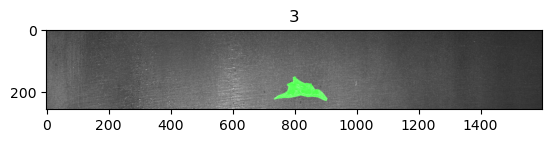

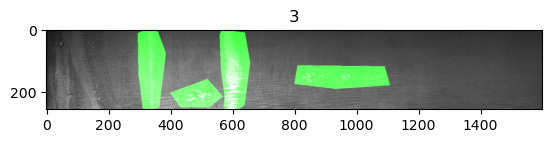

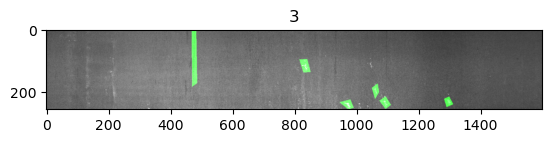

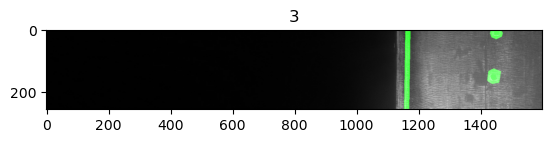

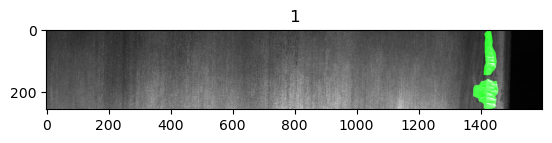

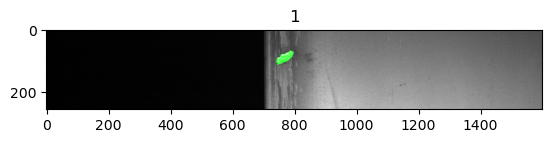

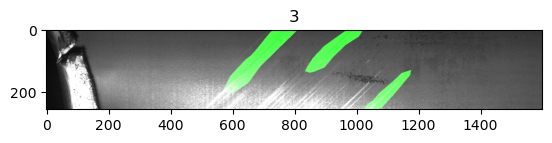

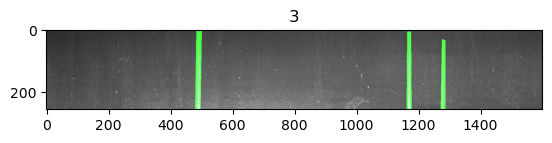

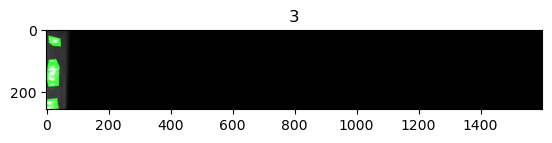

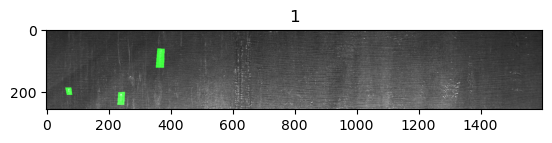

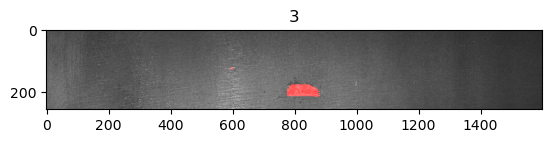

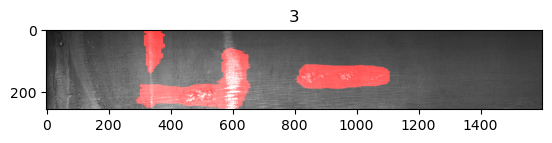

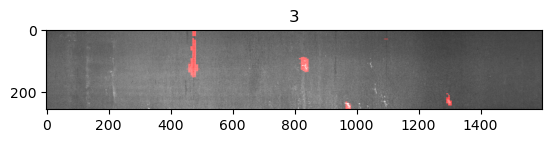

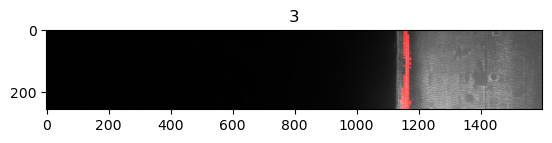

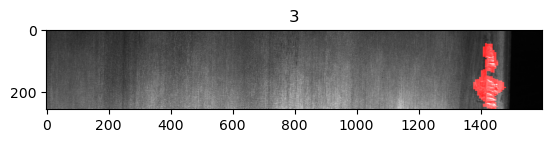

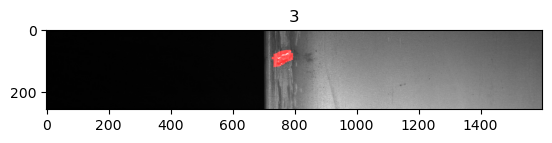

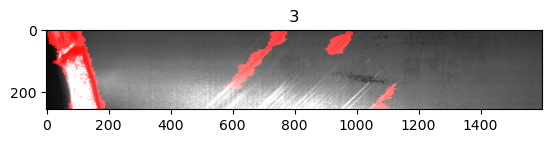

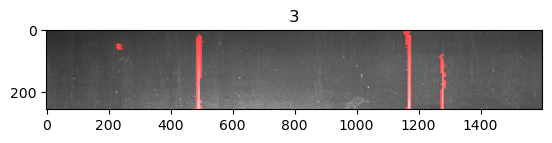

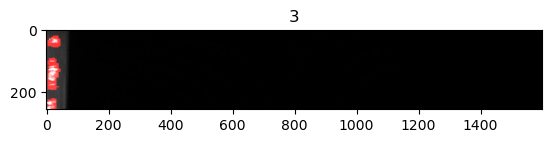

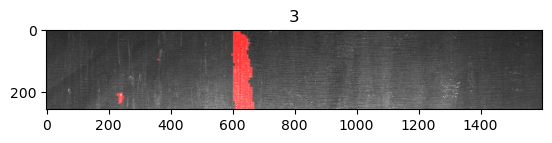

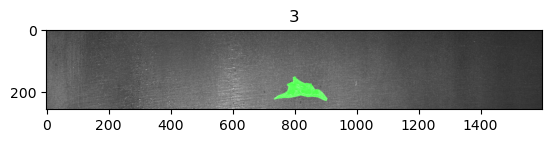

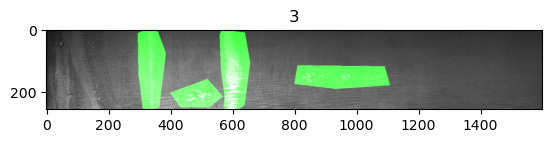

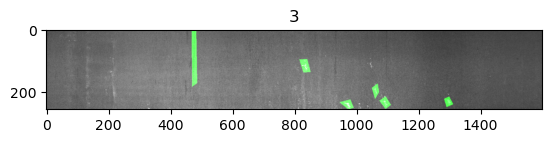

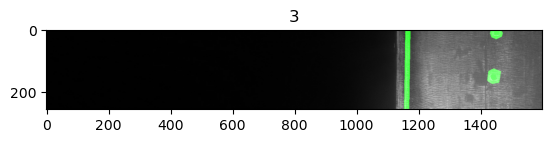

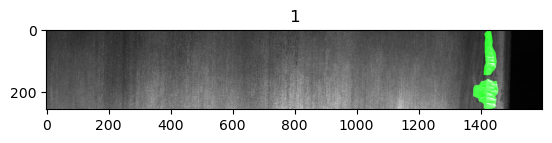

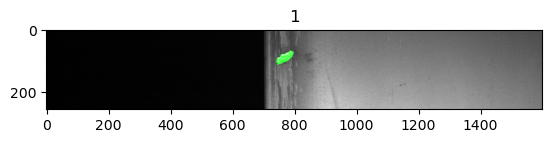

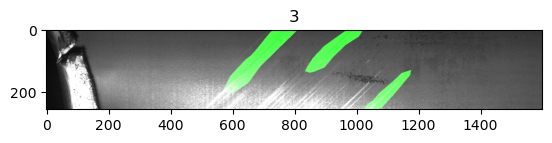

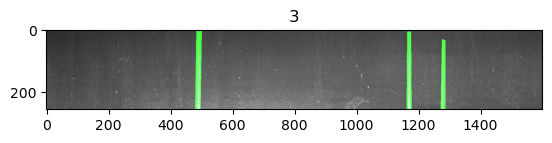

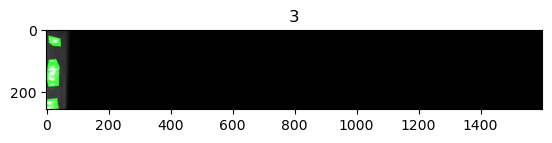

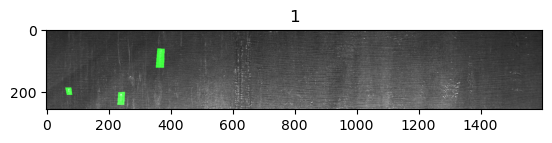

In [67]:
# Shows the images along with their original (ground truth) masks
for i in range(10):

  # Reads the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtain mask for the image from rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)
  plt.show();

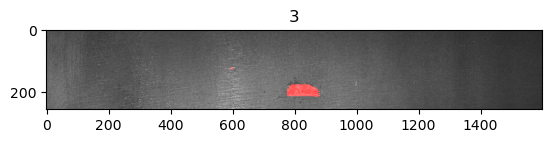

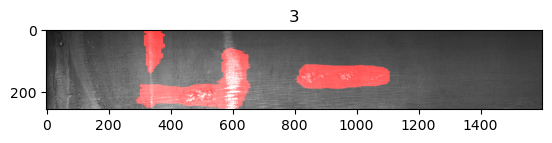

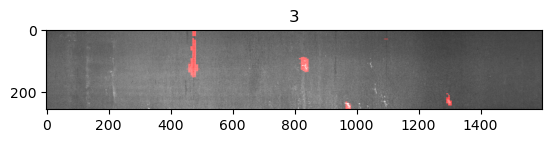

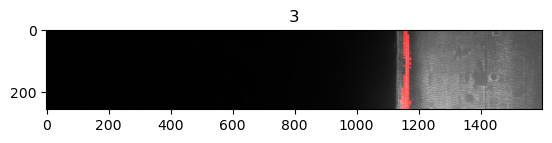

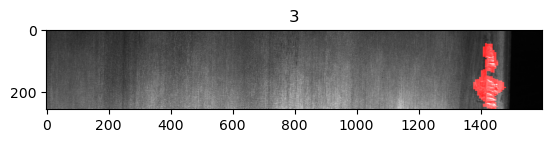

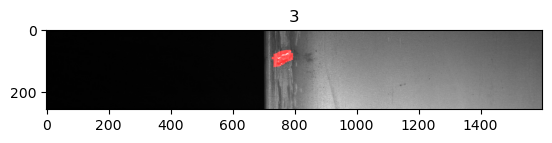

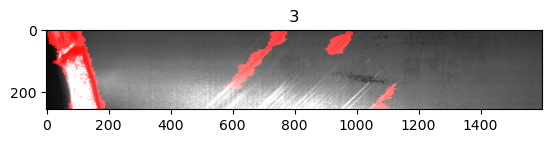

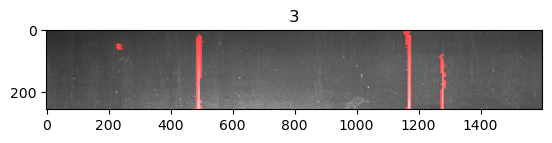

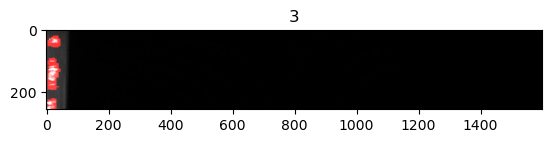

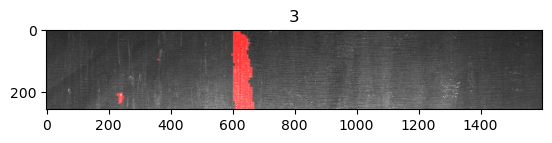

In [68]:
# Visualize the results (model predictions)

directory = "train_images"

for i in range(10):

  # Reads the images using opencv and convert to rgb format
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)
  plt.show();

## Summary of Findings

The analysis revealed that the defect detection model can accurately (~87%) identify and localize defects in images. The visualizations of the model predictions show that the defect masks are correctly overlaid on the original images, highlighting the areas with defects.

## Recommendations

Based on the findings from the notebook, the following recommendations are made to improve defect detection:

1. **Data Augmentation**: Implement data augmentation techniques to increase the diversity of the training data and improve model robustness.
2. **Model Tuning**: Experiment with different model architectures and hyperparameters to enhance model performance.
3. **Regular Updates**: Regularly update the model with new data to ensure it remains accurate and relevant.
4. **Real-time Detection**: Explore the possibility of deploying the model for real-time defect detection in production environments.
5. **Continuous Monitoring**: Continuously monitor the model's performance and retrain it as needed to maintain high accuracy.

These recommendations aim to help the organization improve defect detection and ensure high-quality products.